In [1]:
import tensorflow as tf
import cv2
import glob
import random
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preprocess masks

### marker-to-mask converter

In [2]:
def make_mask(marker_string, nv, nh):
    # initial mask is empty 1D array
    mask = np.zeros(nv * nh)
    
    # if markers exist, add detect part according to markers
    if len(marker_string) > 0:
        markers = np.array(marker_string.split(' ')).reshape(-1, 2)
        for marker in markers:
            start = int(marker[0])
            length = int(marker[1])
            mask[start: start+length] = 1.0
            
    mask = np.reshape(mask, (nv, nh))

    return mask            

### extract the first N image IDs and their masks

In [3]:
N = 400 # read the top N rows from file => will get N/4 masks
D0 = 256
D1 = 1600

train_mask_file = "data/train.csv"

with open(train_mask_file, "r", newline="") as f:
    reader = csv.reader(f)
    header = next(reader)
    print("CSV header: {}".format(header))
    
    masks = dict()
    for i, row in enumerate(reader):
        if i < N:
            # read image id and defect type
            img_id, defect_type = row[0].split('.jpg_')
        
            # process mask
            mask_marker_string = row[1]
            mask = make_mask(mask_marker_string, D0, D1)
        
            if img_id in masks:
                # if "masks" already has this image's mask(s), add this mask to the right channel
                masks[img_id][:, :, int(defect_type) - 1] = mask
            else:
                # if "masks" doesn't contain this image's info, create a 4-channel mask with zeros
                masks[img_id] = np.zeros((D0, D1, 4))  # dict({defect_type: mask})

CSV header: ['ImageId_ClassId', 'EncodedPixels']


In [4]:
# random.seed(2)
# img_id_0 = random.choice(list(masks.keys()))
# print(img_id_0)
# print(masks[img_id_0])

# Preprocess training images

## Import images

In [5]:
train_img_dir = 'data/train_images/'
train_img_suffix = '.jpg'

def get_image(img_id):
    image_path = train_img_dir + img_id + train_img_suffix
    print(image_path)
    # import image
    image = mpimg.imread(image_path)
    image = image / 255.0
    return image

## Create dataset

In [6]:
image_list = []
mask_list = []
serial_list = []
for serial, mask in masks.items():
    image = get_image(serial)
    image_list = image_list + [image]
    mask_list = mask_list + [mask]
    serial_list = serial_list + [serial]

ds = tf.data.Dataset.from_tensor_slices((np.array(image_list), np.array(mask_list)))
ds = ds.batch(batch_size=10)

data/train_images/0002cc93b.jpg
data/train_images/00031f466.jpg
data/train_images/000418bfc.jpg
data/train_images/000789191.jpg
data/train_images/0007a71bf.jpg
data/train_images/000a4bcdd.jpg
data/train_images/000f6bf48.jpg
data/train_images/0014fce06.jpg
data/train_images/001982b08.jpg
data/train_images/001d1b355.jpg
data/train_images/001d3d093.jpg
data/train_images/0025bde0c.jpg
data/train_images/002af848d.jpg
data/train_images/002e73b3c.jpg
data/train_images/002fc4e19.jpg
data/train_images/0030401a5.jpg
data/train_images/003ac9d2a.jpg
data/train_images/0046839bd.jpg
data/train_images/005b92582.jpg
data/train_images/005d86c25.jpg
data/train_images/005da33cf.jpg
data/train_images/005dbf0e0.jpg
data/train_images/005f02e20.jpg
data/train_images/005f19695.jpg
data/train_images/006a4402e.jpg
data/train_images/0074d81d0.jpg
data/train_images/00762aa3b.jpg
data/train_images/007f28bba.jpg
data/train_images/008479d08.jpg
data/train_images/008621629.jpg
data/train_images/0088260da.jpg
data/tra

# Set up model

## Define model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(D0, D1, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(D0, D1, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2DTranspose(4, kernel_size=3, strides=4, padding='same', activation='softmax')
])

## Configure training

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
pred_0 = model.predict(ds)
pred_0.shape

(100, 256, 1600, 4)

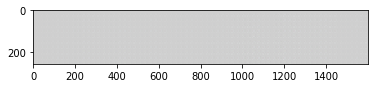

In [10]:
plt.imshow(pred_0[2])

In [11]:
model_history = model.fit(ds, epochs=10)

W0903 13:07:21.148752 140451493463872 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.
W0903 13:07:22.108864 140451493463872 deprecation.py:323] From /home/wei-chun/gohome/src/github.com/wcchu/Severstal/env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10


InvalidArgumentError:  Incompatible shapes: [10,256,1600,4] vs. [10,256,1600]
	 [[node metrics/accuracy/Equal (defined at <ipython-input-11-a1e8a855bdd2>:1) ]] [Op:__inference_keras_scratch_graph_1064]

Function call stack:
keras_scratch_graph
